### First let's get a time series

In [2]:
import numpy as np
import pandas as pd

from ema import read, smooth

# Read in accelerometer data
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

meal_no = 10  # This one seems reasonable (some are before the start of the accelerometer recording)
samples = read.get_participant_meal(device_id, recording_id, participant_id, meal_no)

# Take one axis for now
accel = samples["accel_x"]

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


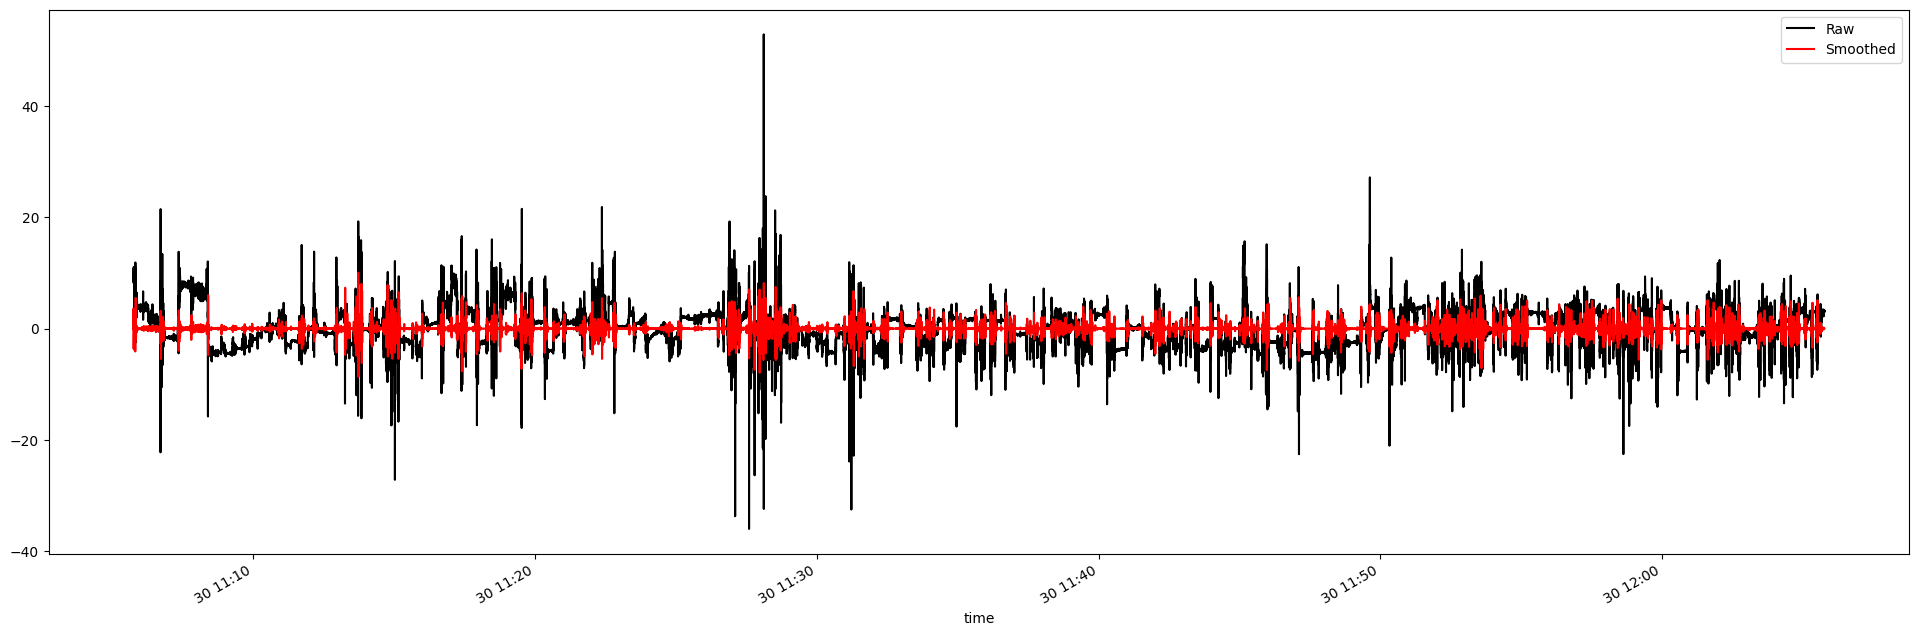

In [3]:
# Filter it
import matplotlib.pyplot as plt

accel -= np.mean(accel)
smoothed_accel= smooth.bandpass_filter(accel, order=3)

# Plot it
fig, ax =plt.subplots(figsize=(24, 8))
accel.plot(ax=ax, color="k", label="Raw")
smoothed_accel.plot(ax=ax, color="r", label="Smoothed")

ax.legend()

### Now let's transform this time series into a form which we can do clustering on

In [37]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from ema import util

# Choose the cluster length
motif_length_sec = 1
motif_length = motif_length_sec * util.SAMPLE_RATE_HZ

# Pad with zeroes to get a time series whose length is a multiple of the motif length
# Pads both front and back of the array
padded_accel: np.ndarray = np.pad(
    smoothed_accel, (0, -len(smoothed_accel) % motif_length), "constant"
)

# Reshape into a matrix of our desired dimension
# For tslearn this should be shape (n, motif_length, d) with dimensionality d=1
padded_accel = padded_accel.reshape(len(padded_accel) // motif_length, motif_length, 1)

# Normalise to have 0 mean and unit variance
padded_accel = TimeSeriesScalerMeanVariance().fit_transform(padded_accel)

In [38]:
# Only take a subset of the points to make training faster, as this is just illustrative
keep = np.random.random(padded_accel.shape[0]) < 0.3
padded_accel = padded_accel[keep, :, :]
print(padded_accel.shape)

(1057, 100, 1)


In [39]:
# Euclidean k-means
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 32
seed = 0
km_softdtw = TimeSeriesKMeans(
    n_clusters=n_clusters, verbose=True, random_state=seed, metric="softdtw", n_jobs=-1
)
km_euclidean =  TimeSeriesKMeans(
    n_clusters=n_clusters, verbose=True, random_state=seed, metric="euclidean", n_jobs=-1
)

y_pred_softdtw = km_softdtw.fit_predict(padded_accel)
y_pred_euclidean = km_euclidean.fit_predict(padded_accel)

19856.454 --> 21404.676 --> 21639.160 --> 21748.138 --> 21811.220 --> 21878.091 --> 21913.922 --> 21940.740 --> 21955.623 --> 21967.840 --> 21977.023 --> 21983.226 --> 21988.749 --> 21994.007 --> 22000.849 --> 22006.220 --> 22010.693 --> 22015.893 --> 22019.923 --> 22025.177 --> 22030.372 --> 22037.552 --> 22044.298 --> 22049.275 --> 22053.821 --> 22058.367 --> 22061.220 --> 22064.743 --> 22066.899 --> 22068.192 --> 22069.521 --> 22071.258 --> 22072.392 --> 22073.572 --> 22074.947 --> 22076.226 --> 22077.019 --> 22077.426 --> 22077.813 --> 22078.081 --> 22078.764 --> 22079.106 --> 22080.017 --> 22080.290 --> 22080.528 --> 22080.729 --> 22081.011 --> 22081.119 --> 22081.222 --> 22081.366 --> 
33.985 --> 28.008 --> 27.374 --> 26.917 --> 26.636 --> 26.476 --> 26.384 --> 26.341 --> 26.319 --> 26.301 --> 26.279 --> 26.260 --> 26.240 --> 26.231 --> 26.215 --> 26.213 --> 26.213 --> 


/tmp/ipykernel_582/3850407347.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([0, 0.5, 1.0])


Text(0.5, 0.98, 'Training Data\nSoft DTW $k$-means')

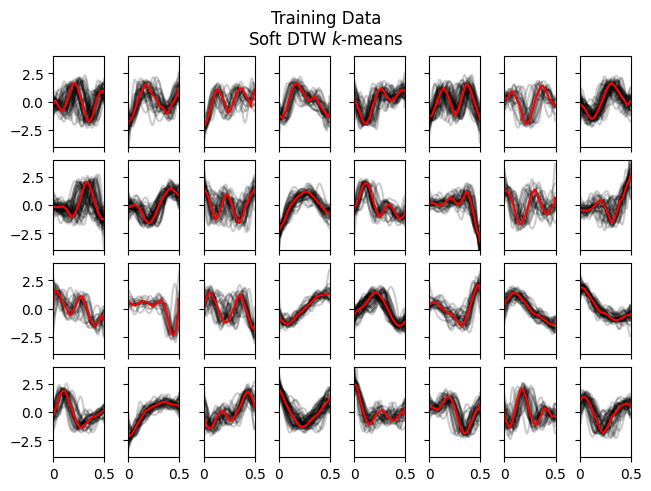

In [40]:
# Plot the discovered motifs and the best fit motif on a grid of axes
n_plots = 4, 8
fig, axes = plt.subplots(*n_plots, sharex=True, sharey=True, constrained_layout=True)

for yi, axis in zip(range(n_clusters), axes.ravel()):
    for xx in padded_accel[y_pred_softdtw == yi]:
        axis.plot(xx.ravel(), "k-", alpha=0.2)
    axis.plot(km_softdtw.cluster_centers_[yi].ravel(), "r-")

    axis.set_xlim(0, motif_length)
    axis.set_ylim(-4, 4)

    axis.set_xticklabels([0, 0.5, 1.0])

fig.suptitle("Training Data\nSoft DTW $k$-means")

/tmp/ipykernel_582/2553148629.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([0, 0.5, 1.0])


Text(0.5, 0.98, 'Training Data\nEuclidean $k$-means')

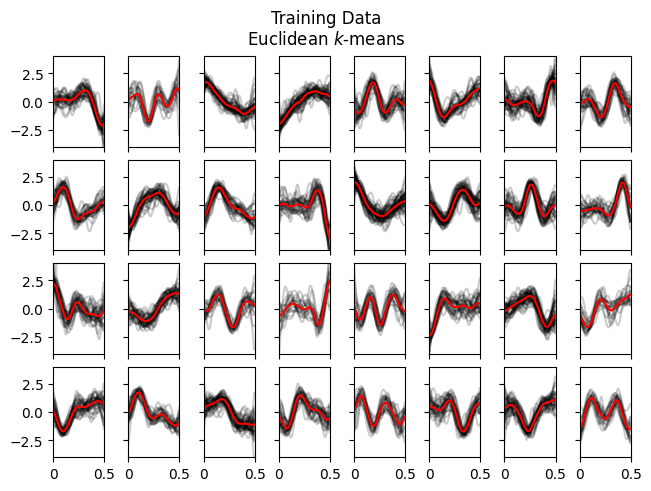

In [41]:
# Plot the discovered motifs and the best fit motif on a grid of axes
fig, axes = plt.subplots(*n_plots, sharex=True, sharey=True, constrained_layout=True)

for yi, axis in zip(range(n_clusters), axes.ravel()):
    for xx in padded_accel[y_pred_euclidean == yi]:
        axis.plot(xx.ravel(), "k-", alpha=0.2)
    axis.plot(km_euclidean.cluster_centers_[yi].ravel(), "r-")

    axis.set_xlim(0, motif_length)
    axis.set_ylim(-4, 4)

    axis.set_xticklabels([0, 0.5, 1.0])

fig.suptitle("Training Data\nEuclidean $k$-means")